In [2]:
import collections.abc
import os
import pprint
import sys
from collections import defaultdict

import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from IPython.display import HTML
from openretina.neuron_data_io import NeuronGroupMembersStore
from openretina.nnfabrik_model_loading import load_ensemble_retina_model_from_directory

# To avoid import errors in DataJoint
if sys.version_info.major == 3 and sys.version_info.minor >= 3:
    # Python 3.3 and later
    collections.MutableMapping = collections.abc.MutableMapping
    collections.Mapping = collections.abc.Mapping
    collections.Iterable = collections.abc.Iterable
else:
    # Python 3.2 or earlier
    collections.MutableMapping = collections.MutableMapping
    collections.Mapping = collections.Mapping
    collections.Iterable = collections.Iterable


%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
neuron_store_path = "/mnt/qb/work/bethge/bkr738/Data/eulerlab_retina/ventral_big_with_confidence.pkl"
model_dir = "/mnt/qb/work/bethge/bkr738/Data/eulerlab_retina/rawModels/bigVentral/"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
sys.version_info.minor

10

In [5]:
neuron_group_member_store = NeuronGroupMembersStore.load_from_file(neuron_store_path)
data_info, ensemble_model = load_ensemble_retina_model_from_directory(
    model_dir, device=DEVICE
)

/Projects/controversial-stimuli-retina/nnfabrik_euler/nnfabrik_euler/models/batch_correction_cores.py:417: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  mask = mask_tf(time.T, stretches, T)
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [6]:
class CustomPrettyPrinter(pprint.PrettyPrinter):
    def _format(self, object, stream, indent, allowance, context, level):
        if isinstance(object, np.ndarray):
            # Print the shape of the array instead of its contents
            stream.write(f"numpy.ndarray(shape={object.shape})")
        else:
            # Use the standard pretty printing for other types
            super()._format(object, stream, indent, allowance, context, level)


pp = CustomPrettyPrinter(indent=4)

pp.pprint(data_info)

{   '20200226_1_1': {   'input_channels': 2,
                        'input_dimensions': (32, 2, 50, 18, 16),
                        'mean_response': numpy.ndarray(shape=(105,)),
                        'output_dimension': 105,
                        'roi_coords': numpy.ndarray(shape=(79, 2))},
    '20200226_1_2': {   'input_channels': 2,
                        'input_dimensions': (32, 2, 50, 18, 16),
                        'mean_response': numpy.ndarray(shape=(110,)),
                        'output_dimension': 110,
                        'roi_coords': numpy.ndarray(shape=(79, 2))},
    '20200226_1_3': {   'input_channels': 2,
                        'input_dimensions': (32, 2, 50, 18, 16),
                        'mean_response': numpy.ndarray(shape=(105,)),
                        'output_dimension': 105,
                        'roi_coords': numpy.ndarray(shape=(79, 2))},
    '20200226_1_4': {   'input_channels': 2,
                        'input_dimensions': (32, 2, 50, 18, 1

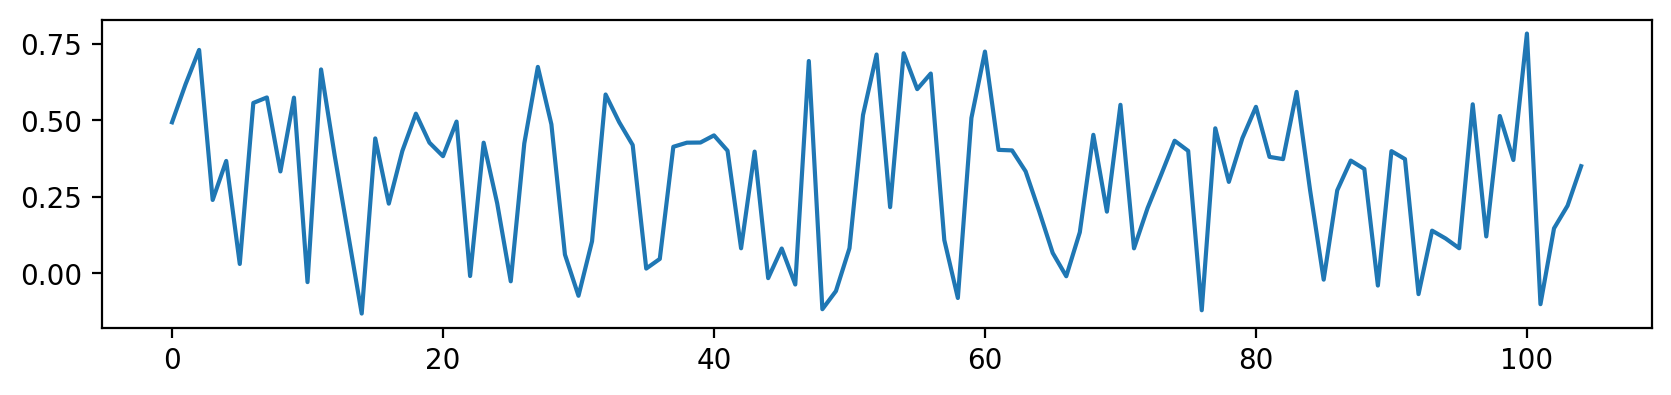

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 2))
plt.plot(data_info["20200226_1_1"]["mean_response"])

In [8]:
rgc_ids = {i for i in range(1, 33)}
neuron_list = neuron_group_member_store.get_all_training_samples(
    list_of_ids=list(rgc_ids), min_confidence=0.25, min_neurons_per_group=50
)

In [9]:
neuron_list

[SingleNeuronInfoStruct(neuron_id='20200226_1_1_7_s_5', neuron_position=5, session_id='20200226_1_1', roi_size=22, celltype=1, celltype_confidences=array([0.42, 0.01, 0.05, 0.14, 0.  , 0.01, 0.03, 0.01, 0.02, 0.02, 0.08,
        0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01,
        0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.01, 0.  ,
        0.  , 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.15, 0.  ,
        0.01, 0.  ]), training_mean=0.0, training_std=1.0),
 SingleNeuronInfoStruct(neuron_id='20200226_1_1_39_s_5', neuron_position=31, session_id='20200226_1_1', roi_size=24, celltype=1, celltype_confidences=array([0.35, 0.01, 0.  , 0.01, 0.01, 0.  , 0.02, 0.  , 0.  , 0.03, 0.33,
        0.01, 0.  , 0.02, 0.  , 0.  , 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
        0.  , 0.  , 0.02, 0.  , 0.01, 0.  , 0.  , 0.  , 0.03, 0.1 , 0.  ,
        0.  , 0.  ]), training_mean=0.0, training_st

In [10]:
example_model = ensemble_model.members[0]

In [11]:
count = sum(1 for key in example_model.state_dict().keys() if "readout" in key and "bias" in key)
count

# One readout per field!

72

In [12]:
type(example_model)

nnfabrik_euler.models.models.SFB3d_core_SxF3d_readout.<locals>.LocalEncoder

In [13]:
postprocessing_config = {
    "norm": 30,
    "x_min_green": -0.654,
    "x_max_green": 6.269,
    "x_min_uv": -0.913,
    "x_max_uv": 6.269,
}

In [65]:
class ChangeNormJointlyClipRangeSeparately:
    """Change the norm, then clip the value of x to some specified range
    Arguments:
        norm (float):   Desired norm
        x_min (float):  Lower valid value
        x_max (float):  Higher valid value
    """

    def __init__(self, norm, x_min_green, x_max_green, x_min_uv, x_max_uv):
        self.norm = norm
        self.x_min_green = x_min_green
        self.x_max_green = x_max_green
        self.x_min_uv = x_min_uv
        self.x_max_uv = x_max_uv

    def __call__(self, x):
        """
        x: torch tensor of shape 1 x channels x time x n_rows x n_cols
        """
        x_norm = torch.norm(x.reshape(len(x), -1), dim=-1)
        renorm = x * (self.norm / x_norm).reshape(len(x), *[1] * (x.dim() - 1))

        # create torch tensors with the min and max values for uv and green
        x_min_green = torch.full(size=x[:, 0].shape, fill_value=self.x_min_green)
        x_max_green = torch.full(size=x[:, 0].shape, fill_value=self.x_max_green)
        x_min_uv = torch.full(size=x[:, 0].shape, fill_value=self.x_min_uv)
        x_max_uv = torch.full(size=x[:, 0].shape, fill_value=self.x_max_uv)
        dichrom_min = torch.stack([x_min_green, x_min_uv], dim=1)
        dichrom_max = torch.stack([x_max_green, x_max_uv], dim=1)
        dichrom_max = dichrom_max.to("cuda")
        dichrom_min = dichrom_min.to("cuda")
        renorm_clipped = torch.max(torch.min(renorm, dichrom_max), dichrom_min)
        return renorm_clipped

In [66]:
normaliser = ChangeNormJointlyClipRangeSeparately(**postprocessing_config)

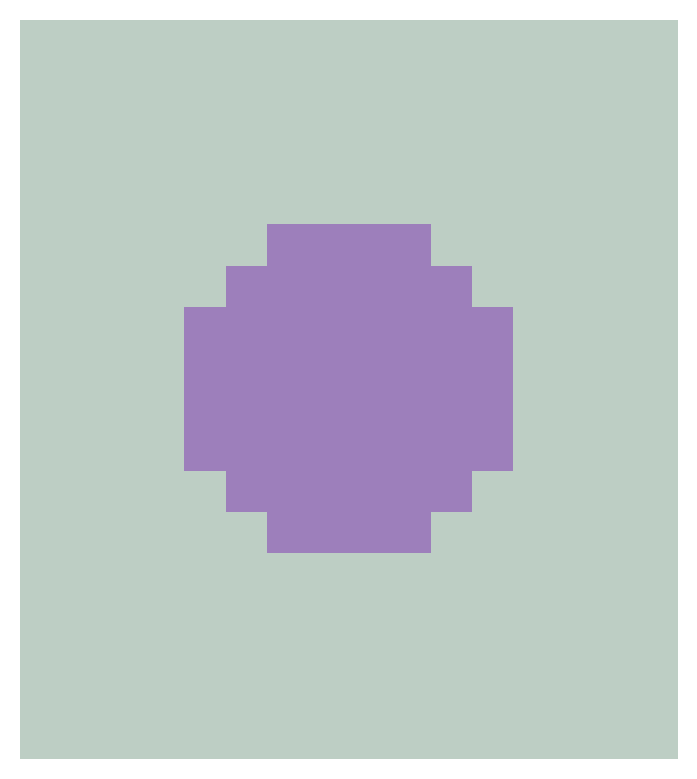

In [137]:
def dot_stimulus(n_channels: int = 2, time: int = 50, w: int = 18, h: int = 16, final_radius: float = 0.5):
    # Create a meshgrid
    xx, yy = torch.meshgrid(torch.linspace(-1, 1, w), torch.linspace(-1, 1, h))

    video_frames = []

    for t in range(time):
        # Calculate the radius for this frame
        minimum_radius = 0.1
        radius = max(final_radius * ((t + 1) / float(time)), minimum_radius)

        # Calculate the distance from the center for each pixel
        distance = torch.sqrt(xx**2 + yy**2)

        # Create a binary mask for the circle
        circle_mask = (distance <= radius).float()

        # Repeat the mask for the number of channels
        circle_image = circle_mask.repeat(n_channels, 1, 1)

        # Invert the first channel
        circle_image[0] = torch.abs(1 - circle_image[1])

        # Store the frame
        video_frames.append(circle_image)

    # Stack the frames
    video = torch.stack(video_frames).transpose(0, 1)

    return video


# Function to animate the frames
def play_stimulus(video: torch.Tensor) -> HTML:
    fig, ax = plt.subplots()

    def update(frame):
        ax.clear()
        ax.imshow(video[0, frame], cmap="Greens", alpha=0.5)
        ax.imshow(video[1, frame], cmap="Purples", alpha=0.5)
        ax.axis("off")

    ani = animation.FuncAnimation(fig, update, frames=len(video[0]), interval=50)
    return HTML(ani.to_jshtml())


# Generate the video
video = dot_stimulus()

# Visualize the video
play_stimulus(video)

In [125]:
input_shape = (2, 50, 18, 16)

random_input = normaliser(torch.rand(input_shape).to(DEVICE).unsqueeze(0))
random_dot = normaliser(dot_stimulus().to(DEVICE).unsqueeze(0))

In [131]:
example_tensor_output = example_model(random_input, data_key="20210929_1_1")
# example_tensor_output = example_model(random_dot, data_key="20200226_1_1")

In [132]:
example_tensor_output.shape

torch.Size([1, 20, 86])

In [133]:
example_output = example_tensor_output.detach().cpu().numpy().squeeze()

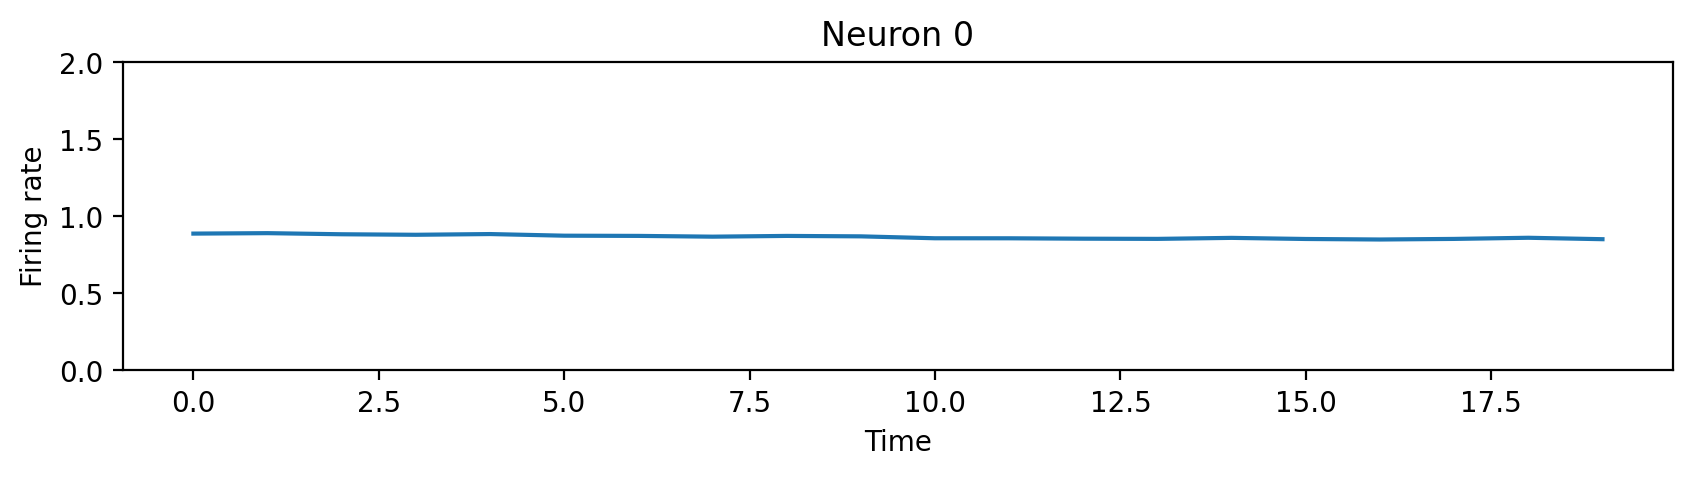

In [134]:
fig, ax = plt.subplots(figsize=(10, 2))


def update(frame):
    ax.clear()
    ax.plot(example_output.T[frame])
    ax.set_title(f"Neuron {frame}")
    ax.set_xlabel("Time")
    ax.set_ylabel("Firing rate")
    ax.set_ylim(0, 2)


ani = animation.FuncAnimation(fig, update, frames=example_output.shape[1], interval=200)

# Display the animation
HTML(ani.to_jshtml())

In [ ]:
def forward(self, inputs):
    result_dict = {}
    neuron_by_session = defaultdict(list)

    if self._neuron_list is None:
        raise NotImplementedError("neuron_list is None, but this is not implemented yet")
        # TODO @ Thomas not sure if we need to implement this or not? If its fast and easy to do, I think it would be good to have

    for neuron in self._neuron_list:
        neuron_by_session[neuron.session_id].append(neuron)

    for session_id, neurons_in_session in neuron_by_session.items():
        # if return_logits is True this will be the logit before the nonlinearity
        firing_rate = self._ensemble_model(inputs, data_key=session_id)
        for neuron in neurons_in_session:
            firing_rate_neuron = firing_rate[
                :,
                self._start_optimization_frame : self._end_optimization_frames,
                neuron.neuron_position,
            ]
            if self._normalize_firing_rates:
                firing_rate_neuron = (firing_rate_neuron - neuron.training_mean) / neuron.training_std
            # TODO: I'm unsure how we deal with batching, I kept the batch dimension
            avg_firing_rate_neuron = torch.mean(firing_rate_neuron, dim=-1)
            result_dict[neuron.neuron_id] = avg_firing_rate_neuron

    sorted_firing_rates_list = [result_dict[neuron.neuron_id] for neuron in self._neuron_list]
    # result.shape = (batch_dim, len(neuron_list))
    result = torch.stack(sorted_firing_rates_list, axis=-1)
    return result